In [40]:
import numpy as np
import pandas as pd
import scipy
from icecream import ic
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1. Geometric Distribution

In [41]:
# Number of outcomes
N = 10_000

# Probability p
p = 0.45

x = np.random.geometric(p=p, size=N)       

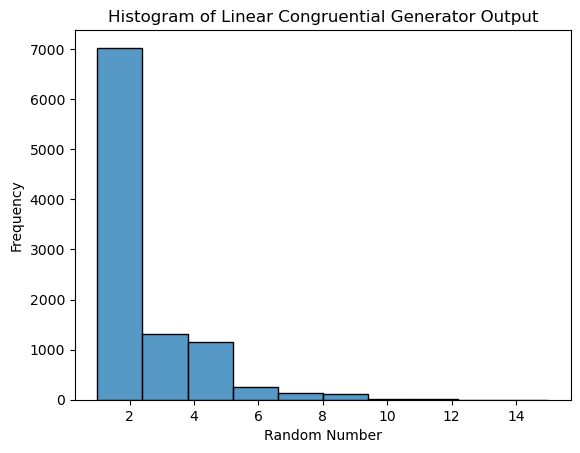

In [42]:
# Plot the histogram
sns.histplot(x, bins=10)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Linear Congruential Generator Output')
plt.show()

# 2. Simulate the 6 point distribution

In [43]:
# Define the outcomes and their probabilities
outcomes = [1, 2, 3, 4, 5, 6]
p = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]

# Simulate 10,000 outcomes
distribution = np.random.choice(outcomes, N, p=p)

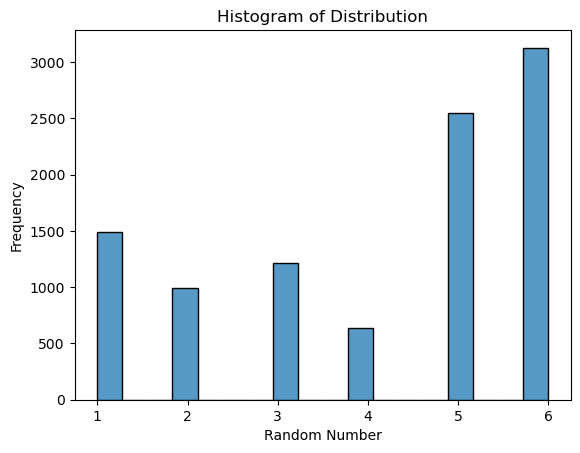

In [44]:
# Plot the histogram
sns.histplot(distribution)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Distribution')
plt.show()

## 2.1 Crude method

In [45]:
x = np.random.rand(10000)
outcomes = [1, 2, 3, 4, 5, 6]
probabilities = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]
accumulated_probabilities = [sum(probabilities[0:i+1]) for i in range(len(probabilities))]
accumulated_probabilities[:0] = [0]
ic(accumulated_probabilities)


ic| accumulated_probabilities: [0, 0.14583333333333334, 0.25, 0.375, 0.4375, 0.6875, 1.0]


[0, 0.14583333333333334, 0.25, 0.375, 0.4375, 0.6875, 1.0]

100%|██████████| 10000/10000 [00:00<00:00, 62244.07it/s]


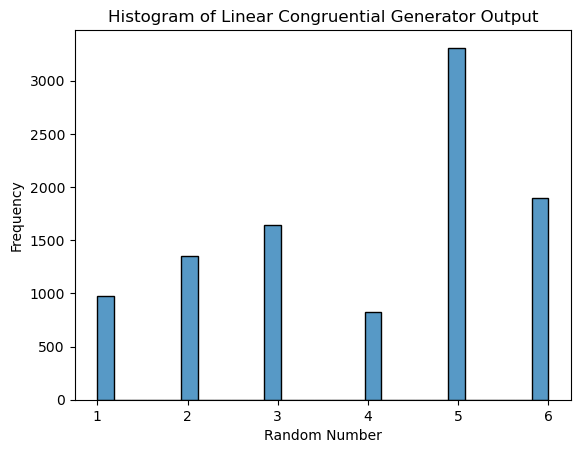

In [51]:
# We make a list of counts 
outcomes = [1, 2, 3, 4, 5, 6]
counts = [0, 0, 0, 0, 0, 0]

lis = []
for _ in tqdm(range(10000)):
    a = True
    while a:
        X = int(np.round(np.random.uniform(1, 6)))
        prev = accumulated_probabilities[X-1]
        next = accumulated_probabilities[X]
        U = np.random.rand()
        if prev < U and U <= next:
            lis.append(X)
            a = False

# Plot the histogram
sns.histplot(lis)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Linear Congruential Generator Output')
plt.show()

## 2.2 Rejection method

ic| np.min(p)/ (1/6): 0.375
ic| Y: array([3., 4., 5., ..., 3., 5., 5.])
  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/sv/_w7_lr4s79bd9y8fpvjxy5d80000gn/T/ipykernel_41073/3953751853.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(np.round(np.random.uniform(1, 6, 1)))
100%|██████████| 10000/10000 [00:00<00:00, 124619.81it/s]


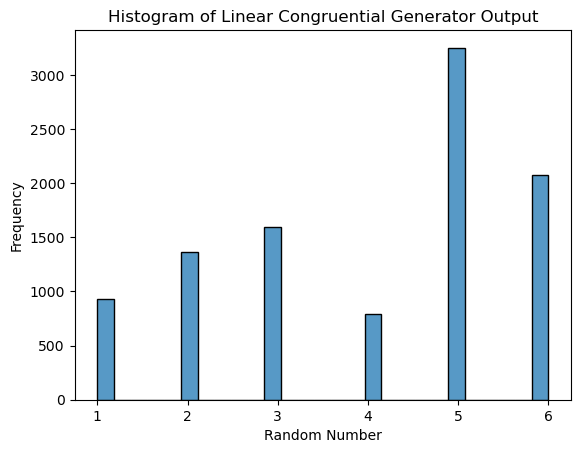

In [47]:
Y = np.round(np.random.uniform(1, 6, 10000),0)
outcomes = [1, 2, 3, 4, 5, 6]
q = np.ones(6) * 1/6 
p = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]

# Minimum value for C
ic(np.min(p)/ (1/6))
C = 0.351

Y= np.round(np.random.uniform(1, 6, 10000))
ic(Y)

lis = []

for _ in tqdm(range(10000)):
    a = True
    while a:
        y = int(np.round(np.random.uniform(1, 6, 1)))
        U2 = np.random.rand()
        sick_value = p[y-1] / (C)
        #ic(y, U2, sick_value, sick_value <= U2)
        if U2 <= sick_value:
            lis.append(y)
            a = False

lis = np.array(lis)
# Plot the histogram
sns.histplot(lis)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Linear Congruential Generator Output')
plt.show()

In [48]:
# compare the probabilities with our distribution
p = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]
our_p = np.unique(lis, return_counts=True)[1] / 10000
ic(p, our_p)

ic| p: [0.14583333333333334, 0.10416666666666667, 0.125, 0.0625, 0.25, 0.3125]
    our_p: array([0.0927, 0.1368, 0.1592, 0.0789, 0.325 , 0.2074])


([0.14583333333333334, 0.10416666666666667, 0.125, 0.0625, 0.25, 0.3125],
 array([0.0927, 0.1368, 0.1592, 0.0789, 0.325 , 0.2074]))

## 2.3 Alias method

ic| alias: array([4, 5, 5, 5, 0, 4])
    prob: array([0.875, 0.625, 0.75 , 0.375, 0.   , 0.625])


n: 6, p: [0.14583333333333334, 0.10416666666666667, 0.125, 0.0625, 0.25, 0.3125], L: [1, 2, 3, 4, 5, 6], F: [0.875 0.625 0.75  0.375 1.5   1.875]
alias: [0 0 0 0 0 0], prob: [0. 0. 0. 0. 0. 0.], G: [4, 5], S: [0, 1, 2, 3]


100%|██████████| 10000/10000 [00:00<00:00, 345673.95it/s]


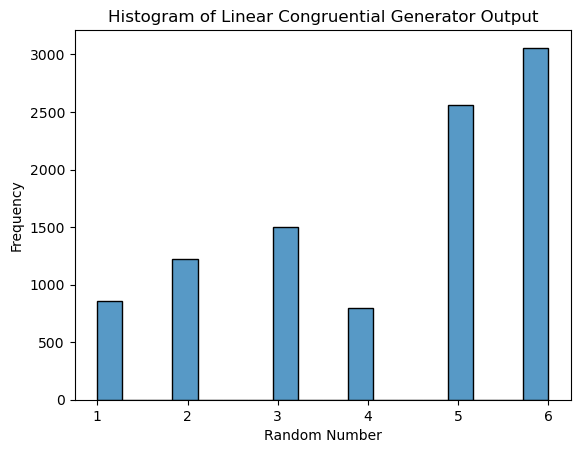

In [50]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

n = 6
p = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]
L = [1, 2, 3, 4, 5, 6]
F = np.array(p) * n  # We scale the probabilities
alias = np.zeros(n, dtype=int)  # Alias
prob = np.zeros(n)

G = []  # Big
S = []  # Small

for i, f in enumerate(F):
    if f >= 1.0:
        G.append(i)
    else:
        S.append(i)

# Debugging information
print(f"n: {n}, p: {p}, L: {L}, F: {F}")
print(f"alias: {alias}, prob: {prob}, G: {G}, S: {S}")

while G and S:
    i = G.pop()  # Big index
    j = S.pop()  # Small index

    # Add indexes where scaled probabilities F is over 1 to the alias indexes 
    #at the locations where the scaled probabilities are smaller
    alias[j] = i

    # Add the scaled probability for the smaller indexes in the smaller indexes 
    prob[j] = F[j]

    F[i] = F[i] - (1 - F[j])

    if F[i] >= 1.0:
        G.append(i)
    else:
        S.append(i)

ic(alias, prob)
# For remaining elements in G and S
while G:
    i = G.pop()
    prob[i] = 1.0

while S:
    i = S.pop()
    prob[i] = 1.0

# List to store samples
samples = []

# Draw samples using the loop structure
for _ in tqdm(range(10000)):
    a = True
    while a:
        I = int(np.round(np.random.uniform(1, 6)))  # Choose a random number from the distribution
        U2 = np.random.rand()  # Generate a uniform random number
        if U2 < prob[I-1]:
            samples.append(I)  # Append the index, +1 for 1-based indexing
        else:
            samples.append(alias[I-1] + 1)  # Append the alias, +1 for 1-based indexing
        a = False  # Exit the while loop

# Plot the results
sns.histplot(samples)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Linear Congruential Generator Output')
plt.show()
